# Figure SX - Constructs

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import brewer2mpl
from scipy import stats

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,model,utils,config

%load_ext autoreload
%autoreload 2

# absolute file path for data directory
# from config import *
from paths import *

In [28]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# normalise by the ancestral population
# pheno_df['growth_rate'] = pheno_df['growth_rate'] - pheno_df[pheno_df.group=='ancestral'].growth_rate.mean()
# def norm(df):
#     df['growth_rate'] = df['growth_rate'] - df[df.group=='ancestral'].growth_rate.mean()
#     return df.reset_index()

# pheno_df = pheno_df.groupby(['selection','environment']).transform(norm)

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'parents')|\
                    (pheno_df.group == 'constructs')|\
                    ((pheno_df.group == 'evolved')&(pheno_df.background == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.selection == 'HU')&(pheno_df.selection_rep == 2)&\
                     (pheno_df.isolate == 2)&(pheno_df.genotype_long == 'rnr2*/RNR2'))|\
                    ((pheno_df.group == 'evolved')&(pheno_df.background == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.selection == 'RM')&(pheno_df.selection_rep == 2)&\
                     (pheno_df.isolate == 6)&(pheno_df.genotype_long == 'tor1*/TOR1'))]

pheno_df = pheno_df.replace('WAxNA','WA/NA')

# duplicate shared controls by candidate gene
groups_1 = pheno_df.groupby(['selection','environment','gene','background'])
for (ii,((env_evo, env_test, gene, population),g1)) in enumerate(groups_1):
    
    if gene!='':
        df = groups_1.get_group((env_evo, env_test,'', population))        
        df = df.replace([env_evo, env_test,'', population],[env_evo, env_test,gene, population])
        
        pheno_df = pheno_df.append(df)

pheno_df = pheno_df[pheno_df.gene != '']
pheno_df = pheno_df.reset_index(drop=True)

# filter out measurement replicates with >5% measurement error
pheno_df['pct'] = pheno_df.groupby(['selection','environment','gene','background','genotype_long'])['growth_rate']\
.apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head()  # show dataframe header to stdout

(12928, 28)
(12928, 28)


,selection,environment,run,index,plate,row,column,id,id_plate,group,...,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,doubling_time,growth_rate,pct
0,RM,RM,1,466,0,9,34,P10_C9,10,constructs,...,,YNR066C,,ynr066cΔ,,MATa,,0.497132,0.708514,-0.087235
1,RM,RM,1,470,0,9,38,P10_C10,10,constructs,...,,YNR066C,,ynr066cΔ,,MATa,,-0.182682,1.134992,0.088727
2,RM,RM,1,474,0,9,42,P10_C11,10,constructs,...,,YNR066C,,ynr066cΔ WA/YNR066C NA,,MATa/α,,0.161159,0.894306,-0.019214
3,RM,RM,1,478,0,9,46,P10_C12,10,constructs,...,,YNR066C,,YNR066C WA/ynr066cΔ NA,,MATa/α,,0.237700,0.848097,-0.036651
4,RM,RM,1,562,0,11,34,P10_C9,10,constructs,...,,YNR066C,,ynr066cΔ,,MATa,,0.317800,0.802292,0.033578


selection  environment
HU         HU             Axes(0.08,0.07;0.87x0.83)
           YNB            Axes(0.08,0.07;0.87x0.83)
RM         RM             Axes(0.08,0.07;0.87x0.83)
           YNB            Axes(0.08,0.07;0.87x0.83)
Name: pct, dtype: object

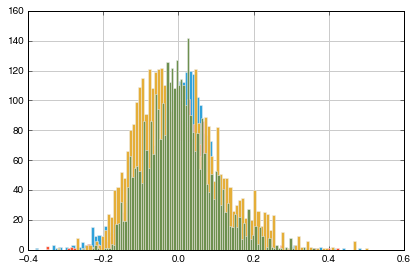

In [20]:
pheno_df.groupby(['selection','environment'])['pct'].hist(bins=100)#set_index(['selection','environment'])#.transform(norm)

In [23]:
from scipy import stats 

stattest=[]

param='growth_rate'

for ((env_evo,env_test,gene),geeg) in pheno_df.groupby(['selection','environment','gene']):
    for ((background,genotype),gbg) in geeg.groupby(['background','genotype_long']):
        if (background,genotype) in config.dict_construct_tests[gene]:
            wt=config.dict_construct_tests[gene][(background,genotype)]#
            mut=(background,genotype)
            wt_data = geeg.groupby(['background','genotype_long']).get_group(wt)[param]
            mut_data = geeg.groupby(['background','genotype_long']).get_group(mut)[param]
            wt_data = wt_data.dropna().tolist()
            mut_data = mut_data.dropna().tolist()
            x_min=min(wt_data+mut_data)
            x_max=max(wt_data+mut_data)
            z_stat,p_val = stats.ranksums(wt_data,mut_data)
            stattest.append([env_evo,env_test,gene,
                             wt,mut,x_min,x_max,
                             z_stat,p_val,utils.stars(p_val)])

stattest = pd.DataFrame(stattest,columns=('selection','environment','gene',
                                          'wt','mut','min','max',
                                          'z_stat','p_val','stars'))

stattest_to_file = stattest.sort_values(['gene','selection', 'environment','p_val'])
stattest_to_file['wt'] = pd.Series(','.join(k) for k in stattest_to_file['wt'])
stattest_to_file['mut'] = pd.Series(','.join(k) for k in stattest_to_file['mut'])
# stattest_to_file.set_index(['gene','selection','env_test']).to_excel(dir_supp+\
#                                                                    'Tables/TableSX_pheno_constructs.xls',
#                                                                    columns=['wt','mut','z_stat','p_val','stars'])

57 2


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


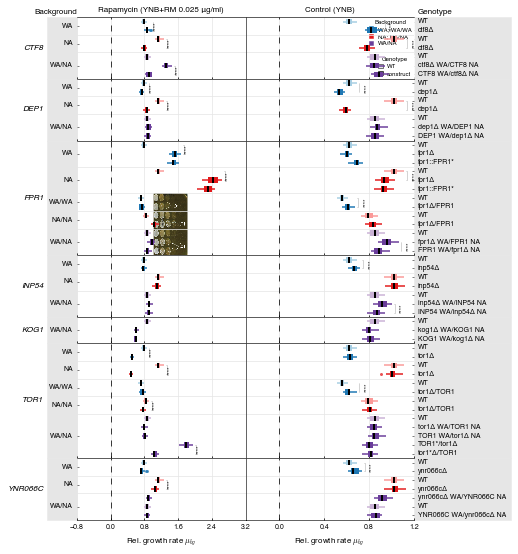

In [27]:
import matplotlib.transforms as transforms

param = 'growth_rate'

color = brewer2mpl.get_map('Paired', 'qualitative', 12).mpl_colors

# background attributes
position_background = {'WA':0, 'NA':1, 'WA/WA':2, 'NA/NA':3, 'WA/NA':4}
color_background_wt = {'WA':color[0], 'NA':color[4], 'WA/WA':color[0], 'NA/NA':color[4], 'WA/NA':color[8]}
color_background_mut = {'WA':color[1], 'NA':color[5], 'WA/WA':color[1], 'NA/NA':color[5], 'WA/NA':color[9]}

# genotype attributes
position_genotype = {
'HU': {u'RNR2':{u'WT':0, u'rnr2Δ':1, u'rnr2Δ/RNR2':2, u'rnr2::RNR2*':3,
                u'rnr2Δ WA/RNR2 NA':4, u'RNR2 WA/rnr2Δ NA':5,
                u'RNR2*/rnr2Δ':6, u'rnr2*Δ/RNR2':7}, 
       u'RNR4':{u'WT':0, u'rnr4Δ':1, u'rnr4Δ/RNR4':2,
                u'rnr4Δ WA/RNR4 NA':3, u'RNR4 WA/rnr4Δ NA':4, u'rnr4::RNR4*':5}},
'RM': {u'CTF8':{u'WT':0, u'ctf8Δ':1,
                u'ctf8Δ WA/CTF8 NA':2, u'CTF8 WA/ctf8Δ NA':3}, 
       u'DEP1':{u'WT':0, u'dep1Δ':1,
                u'dep1Δ WA/DEP1 NA':2, u'DEP1 WA/dep1Δ NA':3},
       u'FPR1':{u'WT':0, u'fpr1Δ':1, u'fpr1Δ/FPR1':2,
                u'fpr1Δ WA/FPR1 NA':3, u'FPR1 WA/fpr1Δ NA':4, u'fpr1::FPR1*':5},
       u'INP54':{u'WT':0, u'inp54Δ':1,
                 u'inp54Δ WA/INP54 NA':2, u'INP54 WA/inp54Δ NA':3}, 
       u'KOG1':{u'WT':0, u'kog1Δ WA/KOG1 NA':1, u'KOG1 WA/kog1Δ NA':2},
       u'TOR1':{u'WT':0, u'tor1Δ':1, u'tor1Δ/TOR1':2, 
                u'tor1Δ WA/TOR1 NA':3, u'TOR1 WA/tor1Δ NA':4, 
                u'TOR1*/tor1Δ':5, u'tor1*Δ/TOR1':6},
       u'YNR066C':{u'WT':0, u'ynr066cΔ':1,
                   u'ynr066cΔ WA/YNR066c NA':2, u'YNR066C WA/ynr066cΔ NA':3}}
}

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['background','genotype_long']).shape
 for k,x in pheno_df.groupby(['selection','environment','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df[pheno_df.selection=='RM'].groupby(['selection'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    nrows=len(gph1.groupby(['background','gene','genotype_long']))
    ncols=len(gph1.groupby(['environment']))
    
    print nrows, ncols
        
    height, width = np.array([nrows*0.125, ncols*3], dtype=float)
    
    fig = plt.figure(figsize=(width, height), dpi=300)
    
    fig.subplots_adjust(left=0.07,bottom=0.01,right=0.85,top=0.99)

    grid = gridspec.GridSpec(1, 2, hspace=0., wspace=0.)
    
    gs = {}
        
    for (jj, ((env_test), gph2)) in enumerate(gph1.groupby(['environment'])):
        
        nrows = len(gph2['gene'].unique())
        ncols = 1
        height_ratios = shape[env_evo,env_test].values.squeeze()
        gs[env_test] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, height_ratios=height_ratios, 
                                                        subplot_spec=grid[0,jj], hspace=0., wspace=0.)
    
        axes = {}
        
        for (kk, ((gene), gph3)) in enumerate(gph2.groupby('gene')):
                        
            gph3.loc[:,'rank_background'] = gph3['background'].map(position_background)
            gph3.loc[:,'rank_genotype'] = gph3['genotype_long'].map(position_genotype[env_evo][gene])
            gph3.sort_values(['rank_background','rank_genotype'], 
                             ascending=[False,False], inplace=True)
      
            if kk == 0:
                axes[env_test] = plt.subplot(gs[env_test][kk])
                ax1 = axes[env_test]
                ax1.set_title(config.dict_environment['long_label'][env_test], fontsize=8)
            else:
                ax1 = plt.subplot(gs[env_test][kk], sharex=axes[env_test])
            
            gph3 = gph3.set_index(['background','genotype_long'], append=True)[param]\
            .unstack(['background','genotype_long'])
            
            # boxplot
            bp = gph3.plot(ax=ax1, kind='box', widths=0.65, vert=False, return_type='dict',
                           labels=gph3.columns.get_level_values('background'))
            
            colors = [color_background_wt[b] if g=='WT' else color_background_mut[b] \
                      for b,g in zip(gph3.columns.get_level_values('background'),gph3.columns.get_level_values('genotype_long'))]
            plot.boxplot_custom(bp, ax1, colors=colors, hatches=['']*30)
            
            for ll, x in enumerate(gph3.columns):
                
                if x in config.dict_construct_tests[gene]:
                    
                    wt_data = gph3[config.dict_construct_tests[gene][x]].dropna()
                    mut_data = gph3[x].dropna()
                    z_stat, p_val = stats.ranksums(wt_data,mut_data)
                                        
                    if p_val < 0.0001:
                    
                        x_min = min(wt_data.min(),mut_data.min())
                        x_max = max(wt_data.max(),mut_data.max())
                             
                        ax1.annotate('', xy=(x_max, ll+1), xycoords='data',
                                     xytext=(x_max, ll+2), textcoords='data',
                                     arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                                     connectionstyle="bar,fraction=-0.3"))
                        ax1.annotate(utils.stars(p_val), 
                                     xy=((x_max+0.025 if env_evo=='HU' else x_max+0.065), ll+1.5), xycoords='data',
                                     ha='left', va='center', fontsize=6, rotation=90)
                        
            if jj==0:
                ax1.annotate(gene, 
                             xy=(-0.2, 0.5), xycoords=("axes fraction", "axes fraction"),
                             ha='right', va='center', annotation_clip=False, 
                             fontsize=8, fontstyle='italic')

            # reset ticks
            ax1.set_yticks([])
            ax1.set_yticklabels([])
            
            ### vertical ###
            ax1.xaxis.grid(ls="-", lw=.75, color="0.9", zorder=0)
            ax1.axvline(x=0., c='k', ls="--", lw=.75, zorder=3)
            
            ### horizontal ###
            
            ## background
            ystart, yend, ylabels = plot.set_custom_labels(gph3.columns, 0)
            
            # grid
            ygrid=[yst+1.5 for yst in list(set(ystart.values()))]
            [ax1.axhline(g, lw=.75, ls="-", color="0.9", zorder=2) for g in ygrid]
            
            # labels
            if jj==0:
                # tick labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True)
                ax1.get_yaxis().tick_left()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Background', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(-0.125, 1.025)
            
            ## genotype
            # labels
            if jj==1:
                # tick labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax1.set_yticks(np.arange(1, len(ylabels)+1), minor=True)
                ax1.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], minor=True)
                ax1.get_yaxis().tick_right()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Genotype', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(1.125, 1.025)
            
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate $\mu_{bg}$', fontsize=10)
            
            if jj==1 and kk==0:
                wa_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA'])
                na_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['NA'])
                wana_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA/NA'])

                leg1 = ax1.legend([wa_artist,na_artist,wana_artist], 
                                  ['WA; WA/WA','NA; NA/NA','WA/NA'], 
                                  ncol=1, loc='upper right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':6}, title='Background', 
                                  labelspacing=.32)

                wt_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.9', edgecolor='k')
                construct_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.1', edgecolor='k')

                leg2 = ax1.legend([wt_artist,construct_artist], 
                                  ['WT','construct'], 
                                  ncol=1, loc='lower right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':6}, title='Genotype', 
                                  labelspacing=.32)
        
                ax1.add_artist(leg1)
        
                for leg in [leg1,leg2]:
                    plt.setp(leg.get_title(),fontsize=6)
                    leg.set_zorder(1)
                    leg.get_frame().set_edgecolor('w')
                    leg.get_frame().set_facecolor('w')
                    
            if env_evo=='RM' and env_test=='RM' and gene=='FPR1':
                transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transData)
                x0, x1, y0, y1 = (1.0, 1.8, .5, 7.5)
                im = ax1.imshow(plt.imread(dir_supp+'figures/figureSX_pheno_constructs/FPR1_LOH_inset.png'),
                                aspect='auto', extent=(x0, x1, y0, y1), transform=transform, zorder=1)
            
            transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transAxes)
            if env_evo=='HU':
#                 ax1.set_xlim(-0.5,0.5)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 4) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 4) )
                if env_test=='HU':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1, 
                                              color='0.9', edgecolor='w', transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.45, height=1,
                                              color='0.9', edgecolor='w', transform=transform, zorder=0)
            elif env_evo=='RM':
#                 ax1.set_xlim(-0.5,1.99)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 5) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 5) )
                if env_test=='RM':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1,#gph3.shape[1]-.15, 
                                              color='0.9', transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.575, height=1,#gph3.shape[1]-.15, 
                                              color='0.9', transform=transform, zorder=0)
                    patch.set_clip_on(False)
            ax1.add_patch(patch)
            patch.set_clip_on(False)

        # tweak axes
        for ax in fig.get_axes():
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.get_xaxis().tick_bottom()
            
            ax.xaxis.label.set_size(8)
            ax.yaxis.label.set_size(8)
            ax.tick_params(axis='both', which='major', size=2, labelsize=7)
            ax.tick_params(axis='both', which='minor', size=2, labelsize=7)
            for sp in ax.spines.values():
                sp.set(color='k', linewidth=.6, linestyle='-')

    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.png' % env_evo, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.svg' % env_evo, 
                dpi=300, bbox_inches='tight')
plt.show()